<a href="https://colab.research.google.com/github/ag826/AIPI590_XAI_F25/blob/main/AIPI509_XAI_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI590_XAI_F25"  # Change to your repo name
git_path = 'https://github.com/ag826/AIPI590_XAI_F25.git'  # Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}"  # Add if using requirements.txt

# Create a subfolder for the notebook
subfolder_name = 'Assignment-Interpretable-ML'
subfolder_path = os.path.join(repo_name, subfolder_name)
!mkdir -p "{subfolder_path}"

# Change working directory to the new subfolder
path_to_notebook = subfolder_path
%cd "{path_to_notebook}"
%ls

rm: cannot remove './sample_data': No such file or directory
Cloning into 'AIPI590_XAI_F25'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 14 (delta 0), reused 4 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (14/14), 430.27 KiB | 3.41 MiB/s, done.
/content/AIPI590_XAI_F25/Assignment-Interpretable-ML/AIPI590_XAI_F25/Assignment-Interpretable-ML
AIPI509_XAI_.ipynb


In [22]:
pip install pygam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 2.4 MB/s eta 0:00:00


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



In [10]:
df=pd.read_csv("/content/AIPI590_XAI_F25/Assignment-Interpretable-ML/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# QUESTION 1

## The following code is to get a deeper understanding of the data available.

In [11]:
print("#####################################################")
print("--- Initial Data Info ---")
print("#####################################################")
print("")
df.info()
print("")
print("#####################################################")
print("--- First 5 Rows of Data ---")
print("#####################################################")
print("")
print(df.head())

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

df.dropna(inplace=True)

df.drop('customerID', axis=1, inplace=True)

df['SeniorCitizen'] = df['SeniorCitizen'].map({'Yes': 1, 'No': 0})
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})


#####################################################
--- Initial Data Info ---
#####################################################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  S

## The following code is to evaluate assumptions regarding the applicability of linear, logistics and GAM models before they are applied.

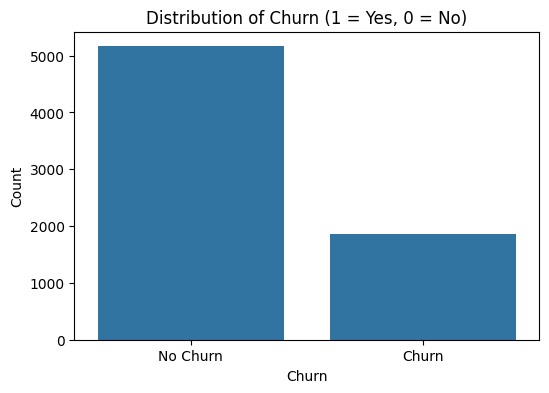

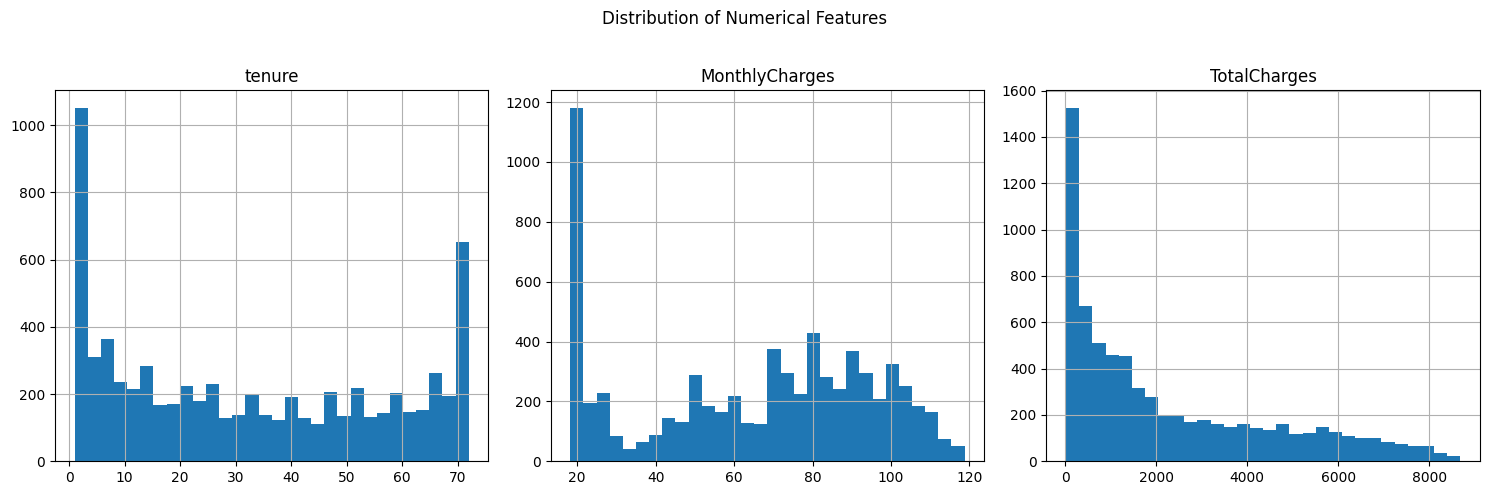

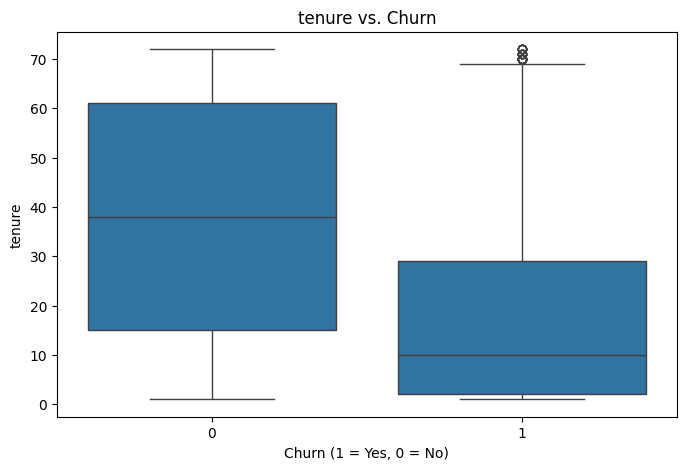

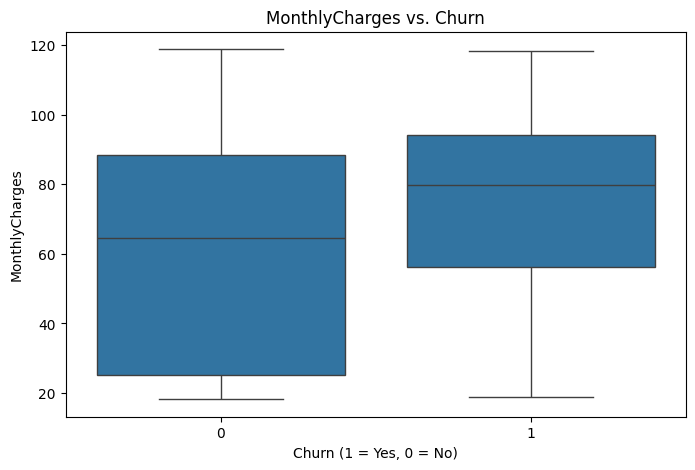

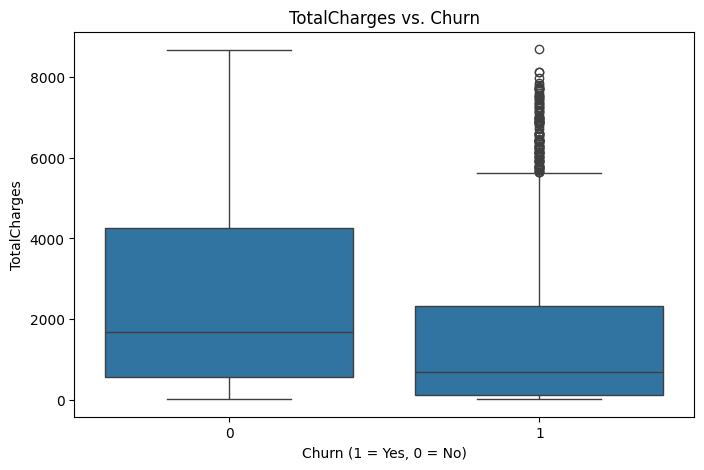

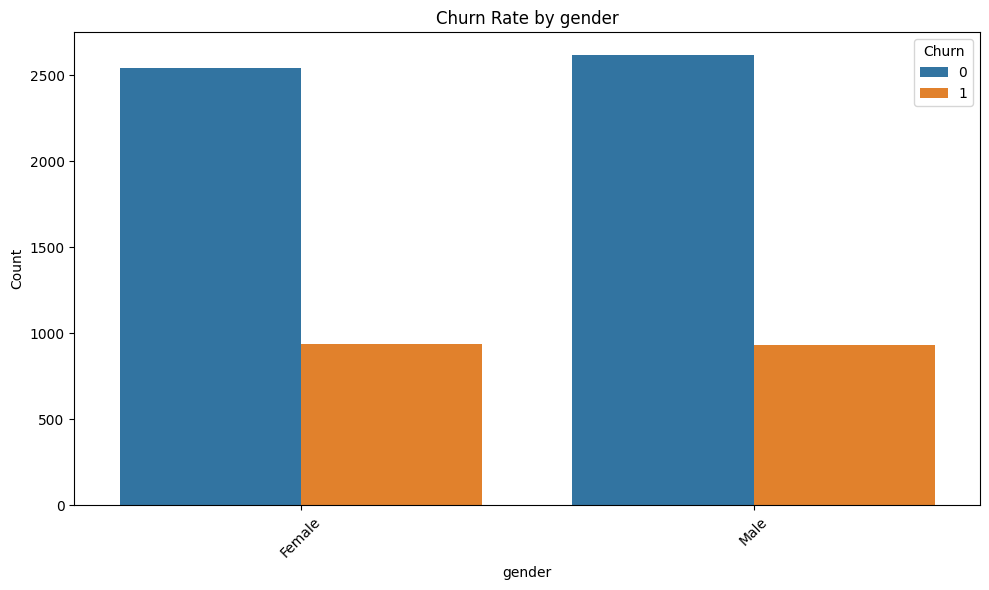

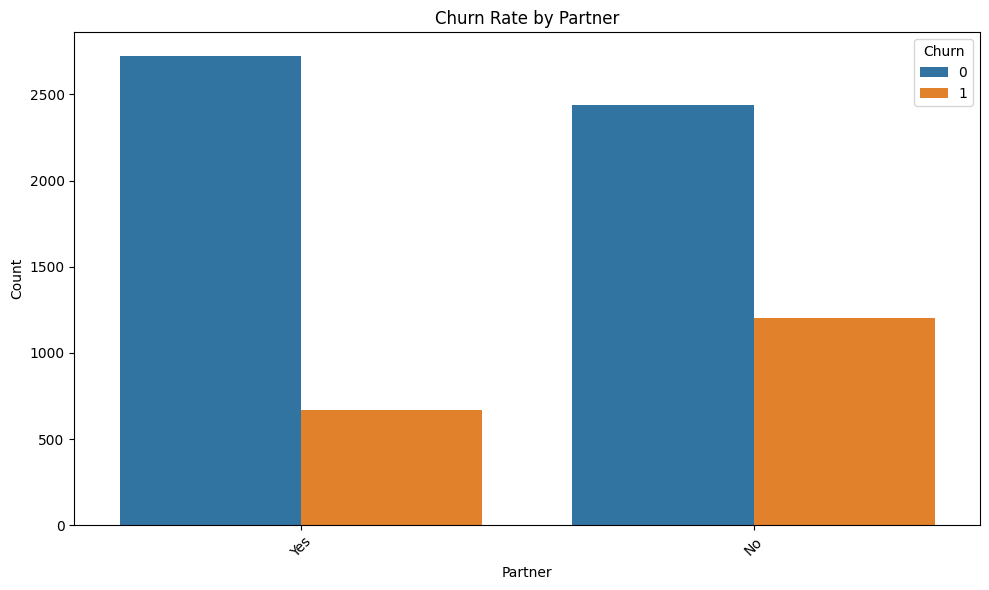

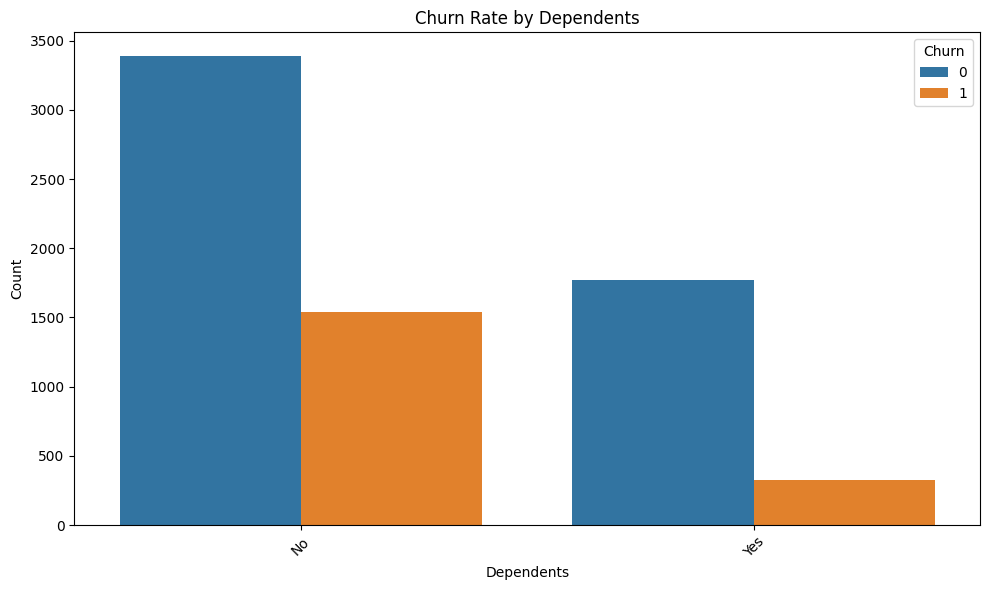

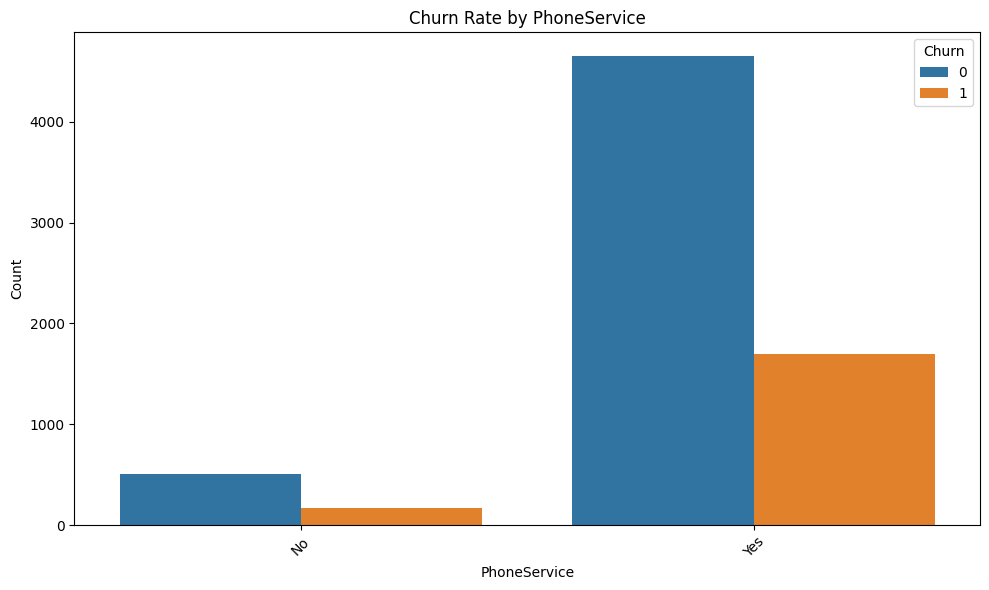

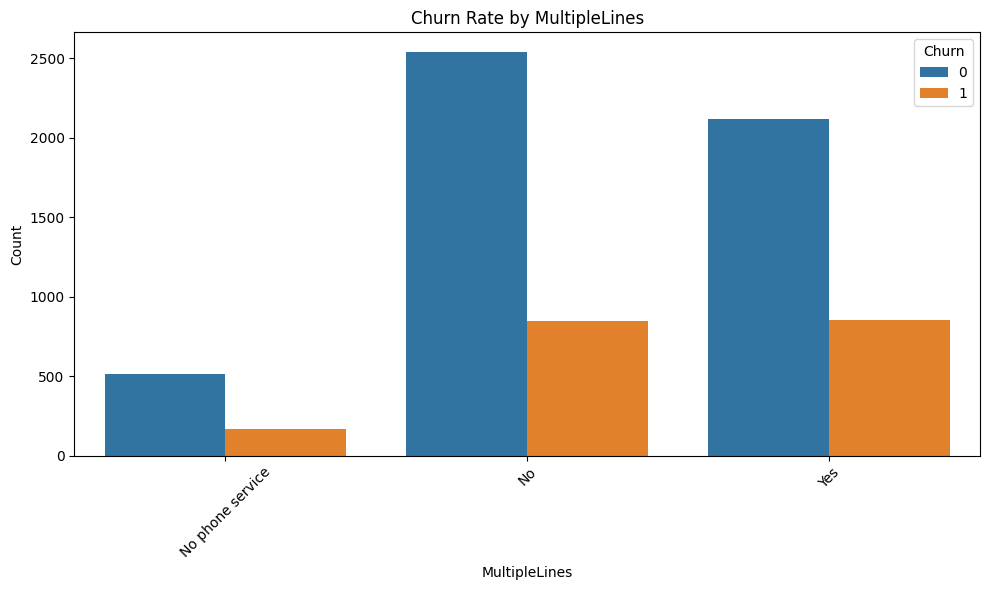

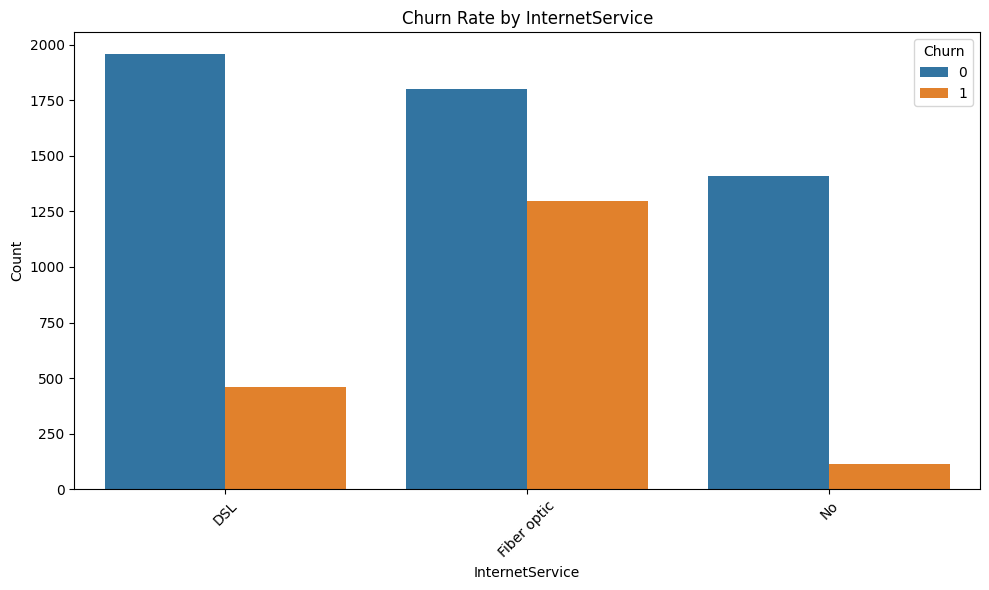

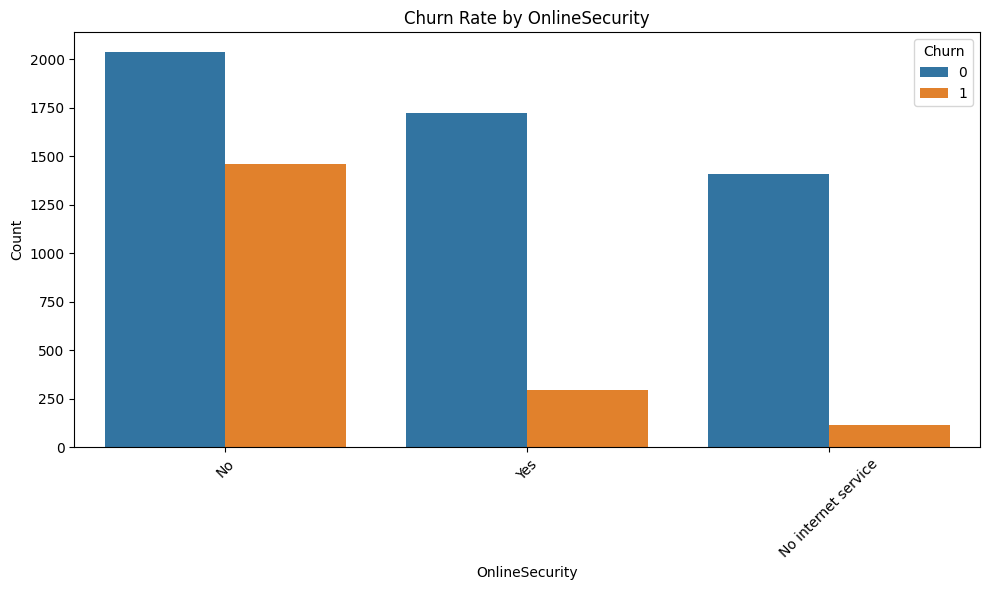

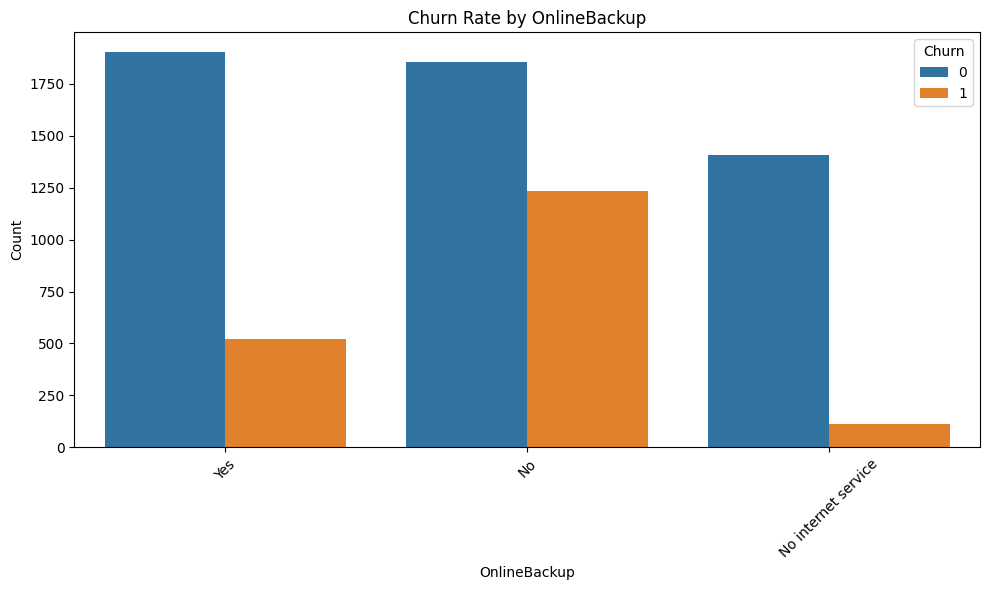

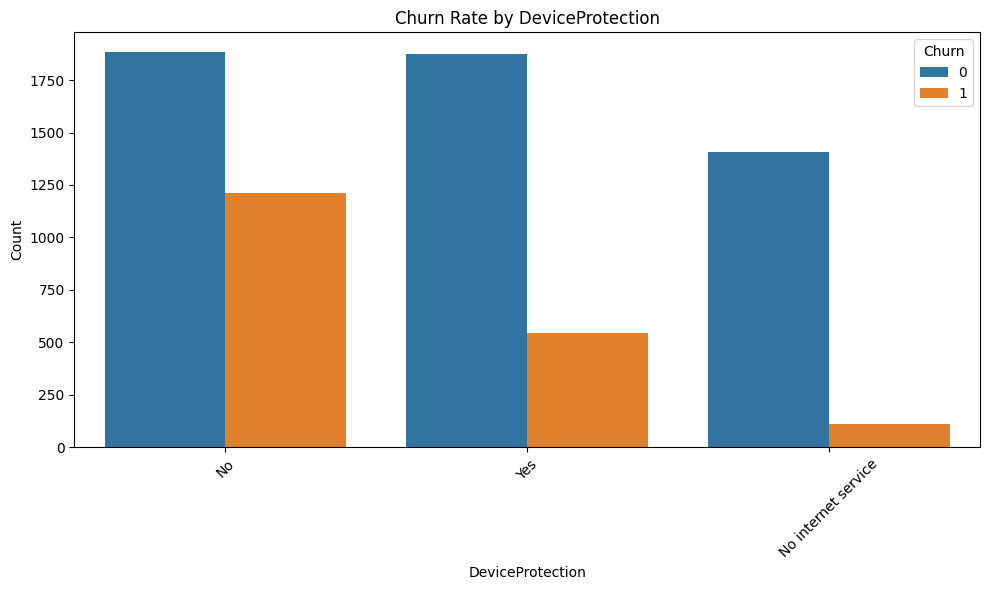

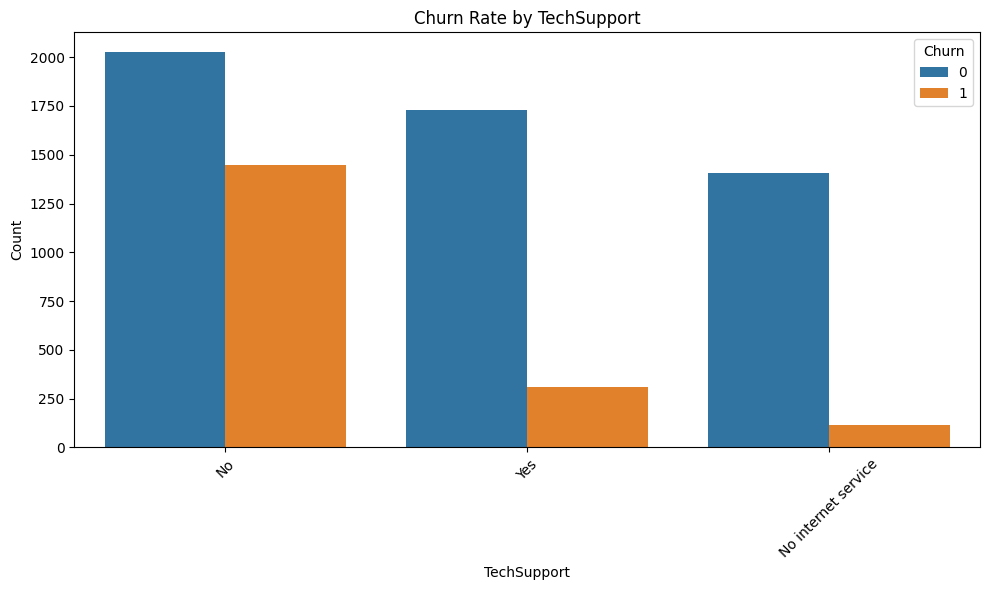

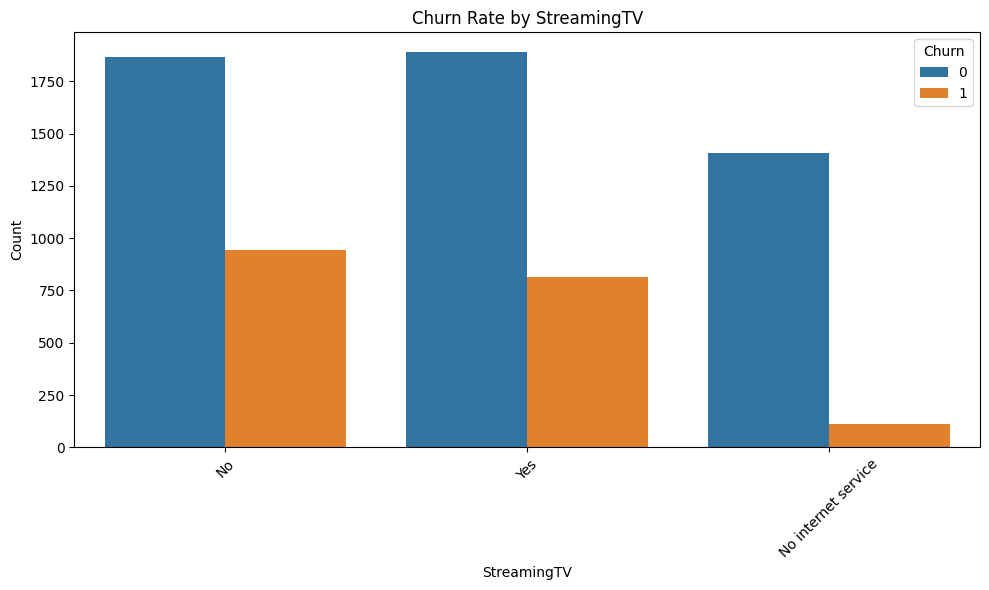

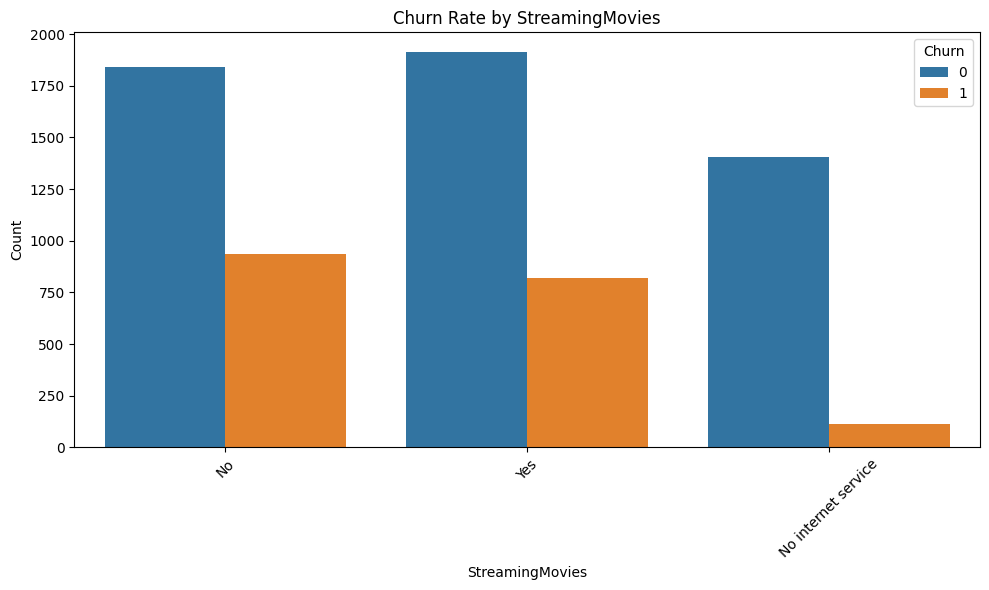

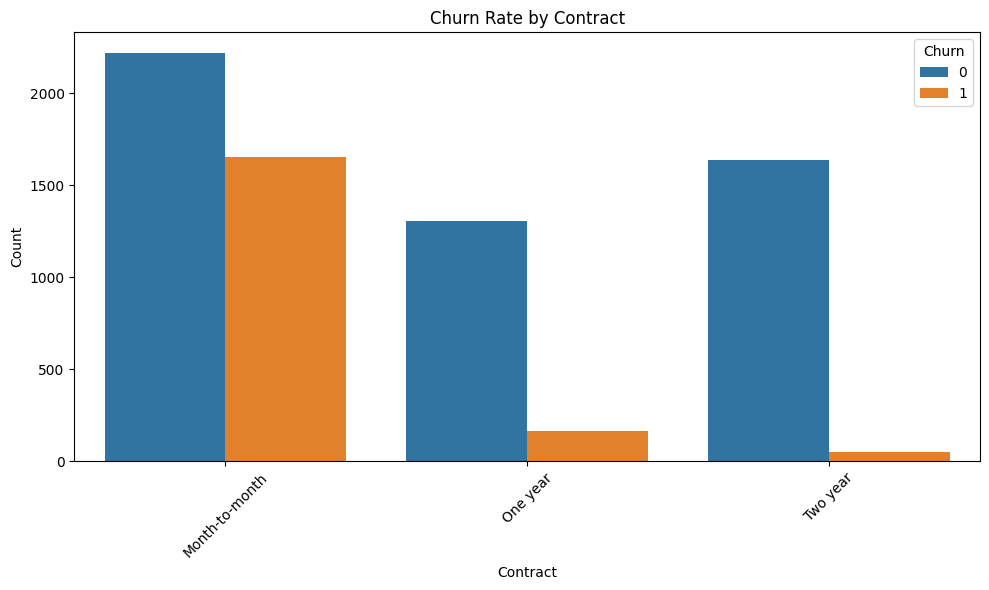

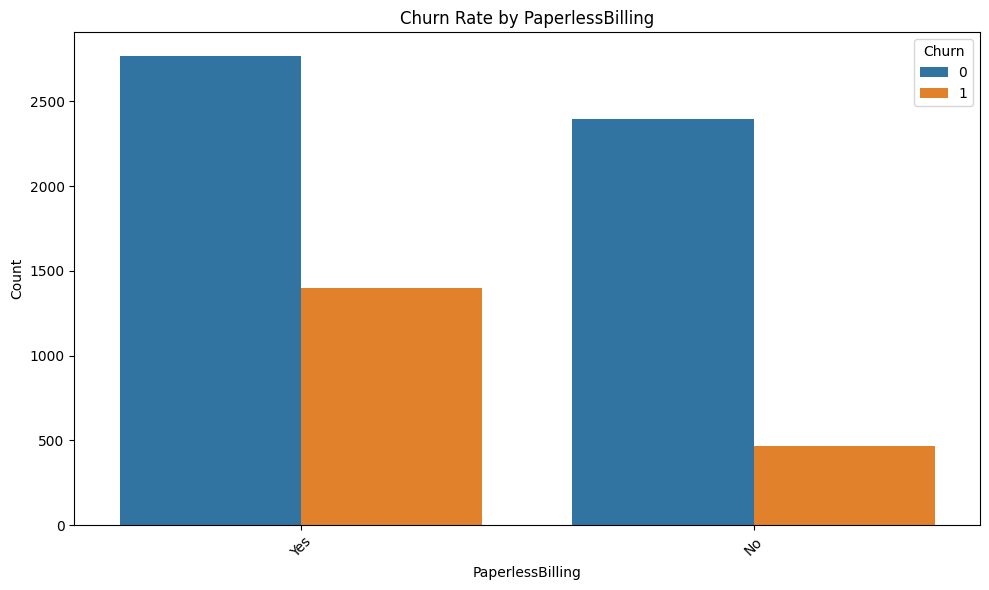

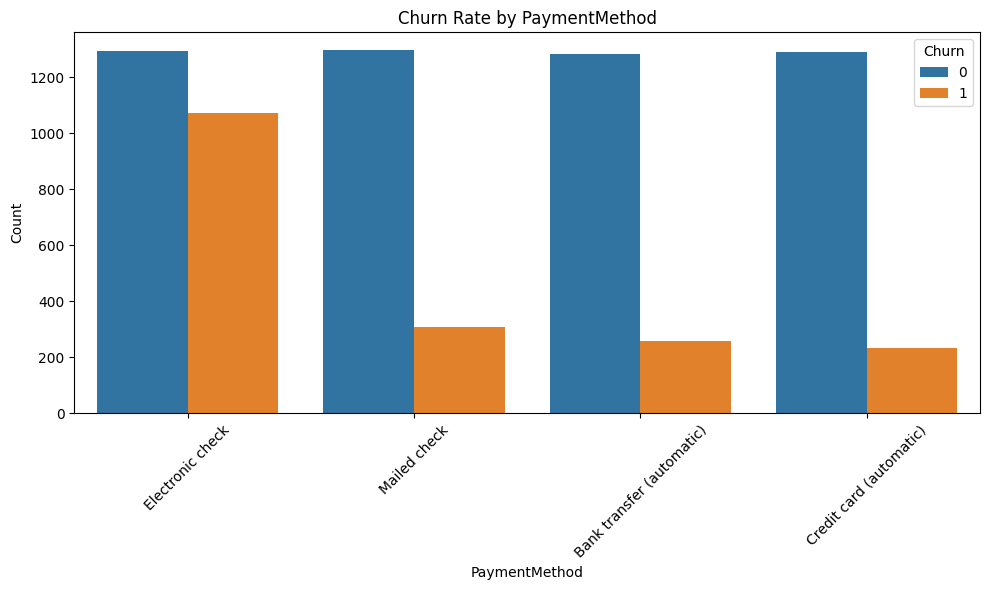

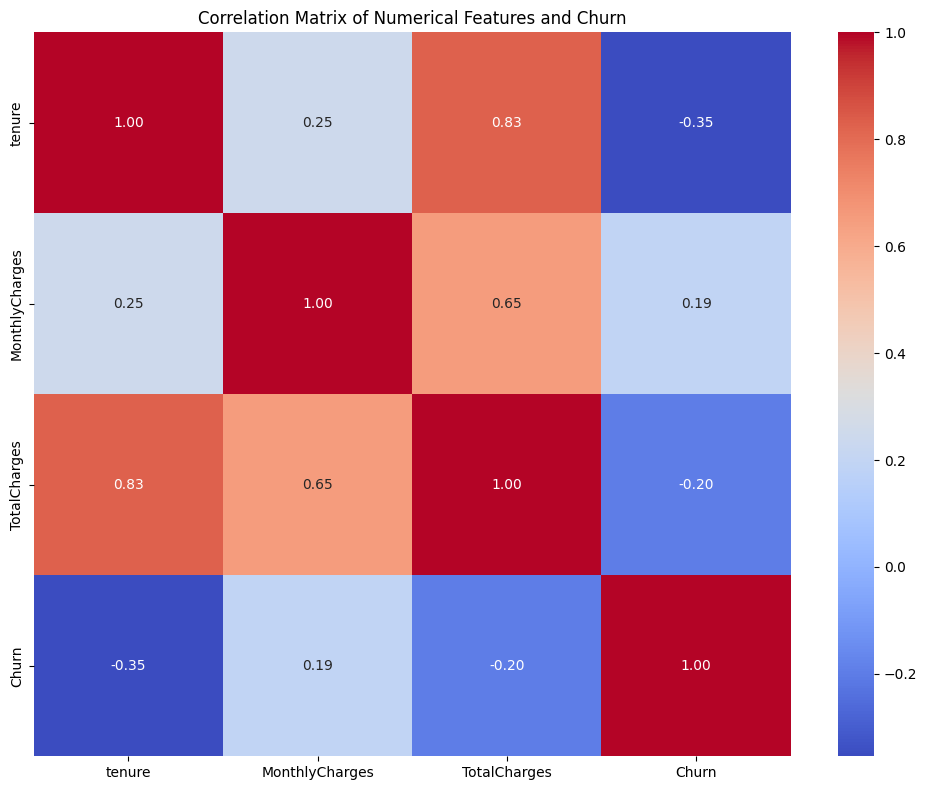

In [12]:


# Churn Distribution
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Churn', data=df)
plt.title('Distribution of Churn (1 = Yes, 0 = No)')
plt.xlabel('Churn')
plt.ylabel('Count')
ax.set_xticks([0, 1])
ax.set_xticklabels(['No Churn', 'Churn'])
plt.show()

# Univariate Analysis of Numerical Features
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numerical_features].hist(bins=30, figsize=(15, 5), layout=(1, 3))
plt.suptitle('Distribution of Numerical Features')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Bivariate Analysis (Numerical vs. Churn)
# This helps check for linearity and group differences, relevant for linear and logistic models.
for feature in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='Churn', y=feature, data=df)
    plt.title(f'{feature} vs. Churn')
    plt.xlabel('Churn (1 = Yes, 0 = No)')
    plt.ylabel(feature)
    plt.show()

# Bivariate Analysis (Categorical vs. Churn)
# This shows the relationship between categorical features and churn.
categorical_features = df.select_dtypes(include=['object']).columns

for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, hue='Churn', data=df)
    plt.title(f'Churn Rate by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Correlation Analysis
# Checking for multicollinearity, a key assumption for linear and logistic regression.
plt.figure(figsize=(10, 8))
corr_matrix = df[numerical_features + ['Churn']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features and Churn')
plt.tight_layout()
plt.show()

# QUESTION 2

Mean Squared Error (MSE): 0.15475092221279652
R-squared (R2): 0.2071630586997173
Coefficients: [-2.65812160e-03  7.26056544e-03 -7.77477794e-05]
Intercept: 0.059881116734811474


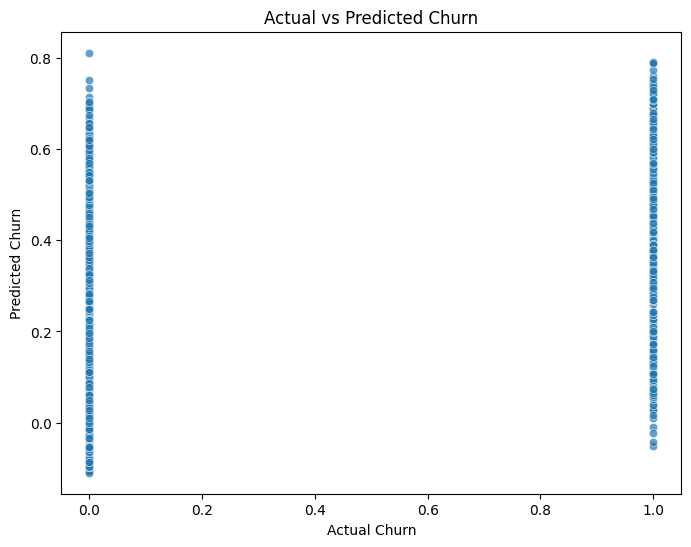

In [18]:
# Select features and target variable
features = [
    "tenure",
    "MonthlyCharges",
    "TotalCharges",
]  # Numerical features for simplicity
X = df[features]
y = df["Churn"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Build a linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on the test set
y_pred = linear_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
coefficients = linear_model.coef_
intercept = linear_model.intercept_

# Print results
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Coefficients:", coefficients)
print("Intercept:", intercept)

# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.title("Actual vs Predicted Churn")
plt.xlabel("Actual Churn")
plt.ylabel("Predicted Churn")
plt.show()

# QUESTION 3


Logistic Regression Results:
Confusion Matrix:
 [[1396  153]
 [ 322  239]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.90      0.85      1549
           1       0.61      0.43      0.50       561

    accuracy                           0.77      2110
   macro avg       0.71      0.66      0.68      2110
weighted avg       0.76      0.77      0.76      2110

Coefficients: [[-0.06950222  0.03093855  0.00016301]]
Intercept: [-1.62816464]


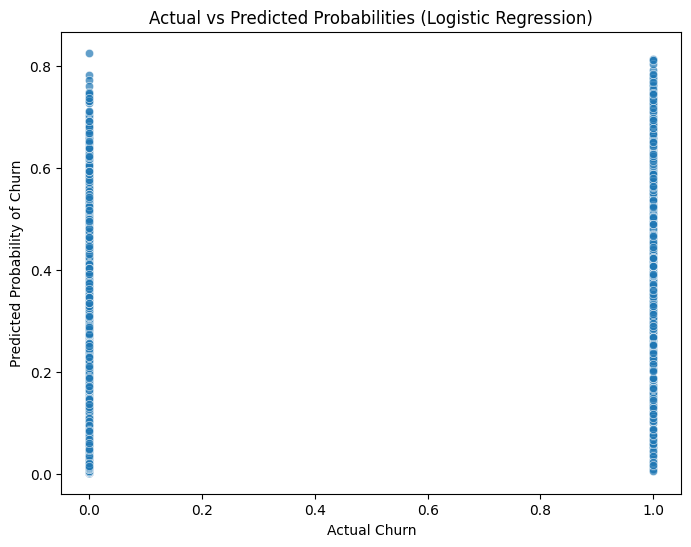

In [19]:

# Logistic Regression Model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Predict on the test set using Logistic Regression
y_pred_logistic = logistic_model.predict(X_test)
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]

# Evaluate Logistic Regression
conf_matrix = confusion_matrix(y_test, y_pred_logistic)
class_report = classification_report(y_test, y_pred_logistic)
logistic_coefficients = logistic_model.coef_
logistic_intercept = logistic_model.intercept_

print("\nLogistic Regression Results:")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("Coefficients:", logistic_coefficients)
print("Intercept:", logistic_intercept)

# Plot actual vs predicted probabilities for Logistic Regression
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_proba, alpha=0.7)
plt.title("Actual vs Predicted Probabilities (Logistic Regression)")
plt.xlabel("Actual Churn")
plt.ylabel("Predicted Probability of Churn")
plt.show()

ModuleNotFoundError: No module named 'pygam'